In [53]:
import pyopencl as cl
import sumpy.toys as t
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from sumpy.visualization import FieldPlotter
from pytools import add_tuples

from sumpy.expansion.local import VolumeTaylorLocalExpansion
from sumpy.expansion.multipole import VolumeTaylorMultipoleExpansion
from sumpy.kernel import (YukawaKernel, HelmholtzKernel, LaplaceKernel)

order = 4

knl = LaplaceKernel(2)

pde = [(1, (2,0)), (1, (0, 2))]

mpole_expn = VolumeTaylorMultipoleExpansion(knl, order)
local_expn = VolumeTaylorLocalExpansion(knl, order)

cl_ctx = cl.create_some_context(answers=["port"])

tctx = t.ToyContext(
        cl_ctx,
        knl,
        mpole_expn_class=type(mpole_expn),
        local_expn_class=type(local_expn),
    
        #YukawaKernel(2), extra_kernel_kwargs={"lam": 5},
        #HelmholtzKernel(2), extra_kernel_kwargs={"k": 0.3},
        )


In [54]:
pt_src = t.PointSources(
        tctx,
        np.random.rand(2, 50) - 0.5,
        np.ones(50))

mexp = t.multipole_expand(pt_src, [0, 0], order)

In [55]:
mexp.coeffs

array([  5.00000000e+01,   2.49673488e+00,   1.47014861e-01,
         2.60554926e+00,  -9.96815120e-01,   2.40178914e+00,
         5.42629997e-02,   3.38317711e-03,   2.93648067e-01,
        -5.10921327e-03,   3.78790947e-02,  -2.80879544e-02,
         1.38914975e-01,  -2.60301325e-02,   3.05226127e-02])

In [56]:
def build_pde_mat(expn, pde):
    coeff_ids = expn.get_coefficient_identifiers()
    id_to_index = expn._storage_loc_dict
    
    # FIXME: specific to scalar PDEs
    pde_mat = np.zeros((len(coeff_ids), len(coeff_ids)))
    
    row = 0
    for base_coeff_id in coeff_ids:
        valid = True
        
        for pde_coeff, coeff_id_offset in pde:
            other_coeff = add_tuples(base_coeff_id, coeff_id_offset)
            if not other_coeff in id_to_index:
                valid = False
                break
                
            pde_mat[row, id_to_index[other_coeff]] = pde_coeff
                
        if valid:
            row += 1
        else:
            pde_mat[row] = 0
            
    return pde_mat[:row]

pde_mat = build_pde_mat(mpole_expn, pde)

In [57]:
def find_nullspace(mat, tol=1e-10):
    u, sig, vt = la.svd(pde_mat, full_matrices=True)
    zerosig = np.where(np.abs(sig) < tol)[0]
    if zerosig:
        nullsp_start = zerosig[0]
        assert np.array_equal(zerosig, np.arange(nullsp_start, pde_mat.shape[1]))
    else:
        nullsp_start = pde_mat.shape[0]
                              
    return vt[nullsp_start:].T
    
nullsp = find_nullspace(pde_mat)

In [64]:
la.norm(pde_mat @ nullsp)

7.3852783309125538e-16

In [61]:
def build_translation_mat(mexp, to_center):
    n = len(mexp.coeffs)
    result = np.zeros((n, n))
    
    for j in range(n):
        unit_coeffs = np.zeros(n)
        unit_coeffs[j] = 1
        unit_mexp = type(mexp)(
            mexp.toy_ctx, mexp.center, mexp.rscale, mexp.order,
            unit_coeffs, derived_from=mexp)
        
        result[:, j] = t.multipole_expand(unit_mexp, to_center).coeffs
        
    return result

tmat = build_translation_mat(mexp, np.array([0, 0.5]))

In [62]:
tmat

array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.5       ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.5       ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        , 

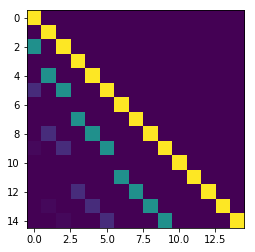

In [63]:
plt.imshow(tmat)